In [1]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM

from extractor import addImagePath, textExtraction, imageExtraction, textExtractReverse

# 1. Load the data and split the data

In [2]:
class OxfordDataset(torch.utils.data.Dataset):
    def __init__(self, text, image, funny_score):
        self.text = text
        self.image = image
        self.funny_score = funny_score
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        text = textExtraction(self.text[idx])
        image = imageExtraction(self.image[idx])
        funny_score = torch.tensor(float(self.funny_score[idx])).unsqueeze(0)
        return text, image, funny_score

In [4]:
# if args.img - dir == 'Oxford_HIC':
dirPath = '../Data/Oxford_HIC/Filtered_oxford_hic_data.csv'
imgPath = '../Data/Oxford_HIC/oxford_img/'
# else:
# dirPath = '../Data/Instagram/Filter_' + 'wendys' + '.csv'
# imgPath = '../Data/Instagram/' + 'wendys' + '_img/'
# load data
data = pd.read_csv(dirPath)
data = addImagePath(data, imgPath)
# Create the dataset and dataloader
train, test = train_test_split(data, test_size=0.2, random_state=42)
train_text = train['caption'].tolist()
train_image = train['image_id'].tolist()
train_funny_score = train['funny_score'].tolist()
test_text = test['caption'].tolist()
test_image = test['image_id'].tolist()
test_funny_score = test['funny_score'].tolist()

train_dataset = OxfordDataset(train_text, train_image, train_funny_score)
test_dataset = OxfordDataset(test_text, test_image, test_funny_score)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
dataL = iter(train_loader)
text, imgs, funny_score = next(dataL)
print("shape of text: ", text.shape)
print("shape of image: ", imgs.shape)
print("shape of funny_score: ", funny_score.shape)

shape of text:  torch.Size([32, 1, 64, 768])
shape of image:  torch.Size([32, 1, 64, 768])
shape of funny_score:  torch.Size([32, 1])


In [5]:
print(text.squeeze(1).shape)
print(imgs.squeeze(1).shape)

torch.Size([32, 64, 768])
torch.Size([32, 64, 768])


# 2. Load Gemma

In [27]:
### 官方的Gemma #########################################################################################
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", device_map="auto",  torch_dtype=torch.bfloat16)
gemmaConfig =  AutoConfig.from_pretrained('google/gemma-2-2b')
########################################################################################################

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
### 官方的Gemma #########################################################################################
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto",  torch_dtype=torch.bfloat16)
gemmaConfig =  AutoConfig.from_pretrained('google/gemma-2-2b-it')
########################################################################################################

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 3. Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # self attention
        self.selfAttentionMultihead = nn.MultiheadAttention(768, 1)
        self.selfAttentionLayerNorm = nn.LayerNorm(768)
        self.selfAttentionLinear = nn.Linear(768, 768)
        self.selfAttentionLayerNorm2 = nn.LayerNorm(768)
        
        # multihead attention
        self.multiheadAttentionMultihead = nn.MultiheadAttention(768, 8)
        self.multiheadAttentionLinear = nn.Linear(768, 768)
        self.multiheadAttentionLayerNorm = nn.LayerNorm(768)
        
        # co-attention text
        self.coAttentionTextMultihead = nn.MultiheadAttention(768, 1)
        self.coAttentionTextLinear = nn.Linear(768, 768)
        self.coAttentionTextLayerNorm = nn.LayerNorm(768)

        # co-attention image
        self.coAttentionImageMultihead = nn.MultiheadAttention(768, 1)
        self.coAttentionImageLinear = nn.Linear(768, 768)
        self.coAttentionImageLayerNorm = nn.LayerNorm(768)
    
        # feed forward
        self.feedForwardLinear = nn.Linear(768, 768)
        self.feedForwardLayerNorm = nn.LayerNorm(768)
        
        # gemma
        self.gemmaLinearMaxTokens = nn.Linear(64, 16)
        self.gemmaLinearBefore = nn.Linear(768, gemmaConfig.vocab_size)
        self.gemmaSoftmax = nn.Softmax(dim=2)
        self.gemma = nn.Sequential(*list(gemma.children())[:-1])
        self.gemmaLm_head = nn.Sequential(*list(gemma.children())[1:])
        
        # funny score
        self.FunnyScorelinear1 = nn.Linear(768, 1)
        self.FunnyScorelinear2 = nn.Linear(64, 1)
        
    def self_multi(self, image, text):
        # self attention module
        self_out = self.selfAttentionMultihead(image, image, image)[0]
        self_out = self.selfAttentionLinear(self_out)
        self_out = self.selfAttentionLayerNorm(self_out + image)

        # multihead attention module
        multi_out = self.multiheadAttentionMultihead(text, text, text)[0]
        multi_out = self.multiheadAttentionLinear(multi_out)
        multi_out = self.multiheadAttentionLayerNorm(multi_out + text)
        
        return self_out, multi_out
        
    def co_attention(self, image, text):
        # co-attention image module
        visual_attending_textual = self.coAttentionTextMultihead(image, text, text)[0]
        visual_attending_textual = self.coAttentionTextLinear(visual_attending_textual)
        visual_attending_textual = self.coAttentionTextLayerNorm(visual_attending_textual + image)
        
        # co-attention text module
        textual_attending_visual = self.coAttentionTextMultihead(text, image, image)[0]
        textual_attending_visual = self.coAttentionTextLinear(textual_attending_visual)
        textual_attending_visual = self.coAttentionTextLayerNorm(textual_attending_visual + text) 
        
        return visual_attending_textual, textual_attending_visual              
        
    def gemmaGenerate(self, x):
        with torch.no_grad():
            # maximum 32 tokens
            x = self.gemmaLinearMaxTokens(x.transpose(1, 2)).transpose(1, 2)
            x = self.gemmaLinearBefore(x)
            x = self.gemmaSoftmax(x)
            # get max value of each row, total 32*64
            top_k_values, top_k_indices = torch.topk(x, 1, dim=2, largest=True)
            toGemma = textExtractReverse(top_k_indices).to(device)
            # 使用gemma作為model的一部分
            output = self.gemma(toGemma)
            # output[0] = last_hidden_state
            # output[1] = past_key_values
            
        return output[0]
               
    
    def forward(self, text, image):
        # max_seq_len = max(text.shape[1], image.shape[1])
        # text = nn.functional.pad(text, (0, 0, 0, max_seq_len - text.shape[1]))
        # image = nn.functional.pad(image, (0, 0, 0, max_seq_len - image.shape[1]))
        text = text.transpose(0, 1)
        image = image.transpose(0, 1)
        
        ######################### Transformer ######################### 
            # self attention
        self_out, multi_out = self.self_multi(image, text)
        # co-attention
        visual_attending_textual, textual_attending_visual = self.co_attention(self_out, multi_out)
        ###############################################################
        
        # feature fusion
        feature_fusion = visual_attending_textual + textual_attending_visual
        feature_fusion = self.feedForwardLinear(feature_fusion)
        feature_fusion = self.feedForwardLayerNorm(feature_fusion + feature_fusion)
        feature_fusion = feature_fusion.squeeze(-1)
        feature_fusion = feature_fusion.transpose(0, 1)
        ####################### gemma  generate #######################
        last_hidden_state = self.gemmaGenerate(feature_fusion)
        output_text = self.gemmaLm_head(last_hidden_state)
        ###############################################################
        
        ######################### funny score #########################
        output_funny_score = self.FunnyScorelinear1(feature_fusion).squeeze(-1)
        output_funny_score = self.FunnyScorelinear2(output_funny_score).squeeze(-1)
        ###############################################################
        
        return output_text, output_funny_score
    
    def generate(self, image, max_length = 100):
        generated_tokens = []
        generated_tokens.append(2) #<bos> = 2
        text = torch.zeros_like(image).to(device)
        text = text.transpose(0, 1)
        image = image.transpose(0, 1)
        tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
        
        # 有時後空格會失效，所以手動插入空格 <pad> = 0
        def insert_zeros(list):
            zeros = [0] * (2 * len(list) - 1)
            zeros[::2] = list
            return zeros
        
        lastTurn = False
        with torch.no_grad():
            for _ in range(max_length + 1):
                # Transformer
                # self attention
                self_out, multi_out = self.self_multi(image, text)
                # co-attention
                visual_attending_textual, textual_attending_visual = self.co_attention(self_out, multi_out)
                
                # feature fusion
                feature_fusion = visual_attending_textual + textual_attending_visual
                feature_fusion = self.feedForwardLinear(feature_fusion)
                feature_fusion = self.feedForwardLayerNorm(feature_fusion + feature_fusion)
                feature_fusion = feature_fusion.squeeze(-1)
                feature_fusion = feature_fusion.transpose(0, 1)
                
                # gemma generate
                last_hidden_state = self.gemmaGenerate(feature_fusion)
                output_text = self.gemmaLm_head(last_hidden_state)
                
                # funny score
                output_funny_score = self.FunnyScorelinear1(feature_fusion).squeeze(-1)
                output_funny_score = self.FunnyScorelinear2(output_funny_score).squeeze(-1)
                
                if lastTurn: # show final funny score
                    return generated_caption, output_funny_score
                else:
                    next_token_logits = output_text[:, -1, :]
                    next_token_probs = torch.softmax(next_token_logits, dim=-1)
                    next_token_id = torch.argmax(next_token_probs, dim=-1).item()
                    generated_tokens.append(next_token_id)
                    
                    generated_caption = insert_zeros(generated_tokens)
                    generated_caption = tokenizer.decode(generated_caption, skip_special_tokens=False)
                    generated_caption = generated_caption.replace("<pad>", " ").replace("  ", " ").split()
                    generated_caption = [word for word in generated_caption if word[0] != "<"]
                    generated_caption = " ".join(generated_caption)
                                               
                    text = textExtraction([generated_caption]).to(device)
                    text = text.transpose(0, 1)
                    
                    if next_token_id in gemmaConfig.eos_token_id or len(generated_caption.split()) > max_length: 
                        #<eos> = 1; <end_of_turn> = 107
                        lastTurn = True

# 5. Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Generator
        self.g_linearFake = nn.Linear(256000, 768)
        self.g_con_mlp1 = nn.Linear(768, 2)
        self.g_con_mlp2 = nn.Linear(128, 1)
        self.g_unc_mlp1 = nn.Linear(768, 1)
        self.g_unc_mlp2 = nn.Linear(64, 1)
        # Discriminator
        self.d_linearFake = nn.Linear(gemmaConfig.vocab_size, 768)
        self.d_con_mlp1_r2f = nn.Linear(768, 2)
        self.d_con_mlp2_r2f = nn.Linear(256, 1)
        self.d_con_mlp1_f2r = nn.Linear(768, 2)
        self.d_con_mlp2_f2r = nn.Linear(256, 1)
        self.d_con_mlp1_g = nn.Linear(768, 2)
        self.d_con_mlp2_g = nn.Linear(128, 1)
        self.d_con_mlp1_m = nn.Linear(768, 2)
        self.d_con_mlp2_m = nn.Linear(128, 1)
        self.d_unc_mlp1_r = nn.Linear(768, 1)
        self.d_unc_mlp2_r = nn.Linear(64, 1)
        self.d_unc_mlp1_g = nn.Linear(768, 1)
        self.d_unc_mlp2_g = nn.Linear(64, 1)
        self.d_unc_mlp1_m = nn.Linear(768, 1)
        self.d_unc_mlp2_m = nn.Linear(64, 1)
        
    def forward(self, real_text, fake_text, image):   
        # real_text = [batch_size, 64, 768]
        # fake_text = [batch_size, 256, 256000]
        # image = [batch_size, 64, 768]
        g_fake_text = self.g_linearFake(fake_text)
        
        d_fake_text = self.d_linearFake(fake_text)
        mismatched_text = torch.roll(real_text, 1, 0)
        
        # conditional (contrastive)
        C_r = torch.cat((real_text, image), dim=1)
        g_C_g = torch.cat((g_fake_text, image), dim=1)
        d_C_g = torch.cat((d_fake_text, image), dim=1)
        C_m = torch.cat((mismatched_text, image), dim=1)
        # contrastive discriminator
        d_C_r2f = torch.cat((C_r, d_C_g), dim=1)
        d_C_f2r = torch.cat((d_C_g, C_r), dim=1)
        ########################## Generator ##########################
        g_C_g = self.g_con_mlp1(g_C_g)
        g_C_g = self.g_con_mlp2(g_C_g.transpose(1,2)).squeeze(-1)
        ###############################################################
        
        ######################## Discriminator ########################
        d_C_r2f = self.d_con_mlp1_r2f(d_C_r2f)
        d_C_f2r = self.d_con_mlp1_f2r(d_C_f2r)
        d_C_g = self.d_con_mlp1_g(d_C_g)
        d_C_m = self.d_con_mlp1_m(C_m)
        d_C_r2f = self.d_con_mlp2_r2f(d_C_r2f.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_C_f2r = self.d_con_mlp2_r2f(d_C_f2r.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_C_g = self.d_con_mlp2_g(d_C_g.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_C_m = self.d_con_mlp2_m(d_C_m.transpose(1,2)).squeeze(-1).unsqueeze(0)
        d_con_output = torch.cat((d_C_r2f, d_C_f2r, d_C_g, d_C_m), dim=0)
        ###############################################################
        
        
        #### unconditional ####
        ########################## Generator ##########################
        g_UC_g = self.g_unc_mlp1(g_fake_text).squeeze(-1)
        g_UC_g = self.g_unc_mlp2(g_UC_g).squeeze(-1)
        ###############################################################
        
        ######################## Discriminator ########################
        d_UC_r  = self.d_unc_mlp1_r(real_text).squeeze(-1)
        d_UC_g  = self.d_unc_mlp1_g(d_fake_text).squeeze(-1)
        d_UC_m  = self.d_unc_mlp1_m(mismatched_text).squeeze(-1)
        d_UC_r = self.d_unc_mlp2_r(d_UC_r).squeeze(-1).unsqueeze(0)
        d_UC_g = self.d_unc_mlp2_g(d_UC_g).squeeze(-1).unsqueeze(0)
        d_UC_m = self.d_unc_mlp2_m(d_UC_m).squeeze(-1).unsqueeze(0)
        d_unc_output = torch.cat((d_UC_r, d_UC_g, d_UC_m), dim=0)
        ###############################################################
        # torch.Size([3, 32, 1])
        return g_C_g, g_UC_g, d_con_output, d_unc_output

In [8]:
# empty cuda memory
import gc
torch.cuda.empty_cache()
gc.collect()

53

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NetG = Generator().to(device)
NetD = Discriminator().to(device)
optimizer_G = optim.Adam(NetG.parameters(), lr=0.001)
optimizer_D = optim.Adam(NetD.parameters(), lr=0.001)
train_losses_FC = []
train_losses_G = []
train_losses_D = []
test_losses_FC = []
test_losses_G = []
test_losses_D = []
save = []
present_epoch = 1
best_train_loss_FC = 9999
best_train_loss_G = 9999
best_train_loss_D = 9999
best_test_loss_FC = 9999
best_test_loss_G = 9999
best_test_loss_D = 9999
loss_data = pd.DataFrame()

checkpoint = False
if checkpoint:
    checkpoint_G = torch.load('./Model/test_save/test_save_2NetG.pth')
    checkpoint_D = torch.load('./Model/test_save/test_save_2NetD.pth')
    NetG.load_state_dict(checkpoint_G['model_state_dict'])
    NetD.load_state_dict(checkpoint_D['model_state_dict'])
    optimizer_G.load_state_dict(checkpoint_G['optimizer_state_dict'])
    optimizer_D.load_state_dict(checkpoint_D['optimizer_state_dict'])
    train_losses_FC.append(checkpoint_G['FC_loss'])
    train_losses_G.append(checkpoint_G['G_loss'])
    train_losses_D.append(checkpoint_G['D_loss'])
    present_epoch = checkpoint_G['epoch'] + 1

    

funnyScoreLoss = nn.MSELoss()

def generatorLoss(condition_logits, uncondition_logits):
    result_fake = (torch.zeros(uncondition_logits.shape[0])).to(device)
    con_loss = CrossEntropyLoss()(condition_logits, result_fake.to(torch.long))
    unc_loss = BCEWithLogitsLoss()(uncondition_logits, result_fake)
    loss = con_loss + unc_loss
    return loss

def discriminatorLoss(condition_logits, uncondition_logits):
    result_true = (torch.ones(uncondition_logits[0].shape[0])).to(device)
    result_fake = (torch.zeros(uncondition_logits[0].shape[0])).to(device)
    
    con_r2f = CrossEntropyLoss()(condition_logits[0], result_fake.to(torch.long))
    con_f2r = CrossEntropyLoss()(condition_logits[1], result_fake.to(torch.long))
    con_f = CrossEntropyLoss()(condition_logits[2], result_fake.to(torch.long))
    con_m = CrossEntropyLoss()(condition_logits[3], result_fake.to(torch.long))
    unc_r = BCEWithLogitsLoss()(uncondition_logits[0], result_true)
    unc_f = BCEWithLogitsLoss()(uncondition_logits[1], result_fake)
    unc_m = BCEWithLogitsLoss()(uncondition_logits[2], result_fake)
    loss = ((con_r2f + con_f2r)/2) + ((con_f + con_m)/2) + unc_r + ((unc_f + unc_m)/2)
    return loss

In [ ]:
save_name = '20241011'
if not os.path.exists('./Model/'+save_name):
    os.makedirs('./Model/'+save_name)
    
epochs = 2
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    print("---------------------------------------- epoch "+ str(epoch + present_epoch) +" ---------------------------------------")
    train_loss_FC = 0
    train_loss_G = 0
    train_loss_D = 0
    test_loss_FC = 0
    test_loss_G = 0
    test_loss_D = 0
    
    ###################################### Train ######################################
    with tqdm(train_loader, unit="batch", leave=True) as tepoch:
        tepoch.set_postfix({'Now': " New batch preprocessing"})
        for text, image, funny_score in tepoch:            
            text = text.squeeze(1)
            image = image.squeeze(1)
            # print(text.shape, image.shape, funny_score.shape)
            # torch.Size([32, 64, 768]) torch.Size([32, 64, 768]) torch.Size([32, 1])
            ######################################################
            # (1) Generate fake caption
            ######################################################
            tepoch.set_postfix({'Now': " Generating fake caption -> Generator"})
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            tepoch.set_postfix({'Now': " Generating fake caption -> Discriminator"})
            g_con_logits, g_unc_logits, d_con_logits, d_unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            ######################################################
            # (3) Update Discriminator network
            #####################################################
            tepoch.set_postfix({'Now': " Updating Discriminator network"})
            optimizer_D.zero_grad()
            loss_D = discriminatorLoss(d_con_logits, d_unc_logits)
            loss_D.backward(retain_graph=True)
            optimizer_D.step()
            train_loss_D += loss_D.item()
            ######################################################
            # (4) Update Generator network
            ######################################################
            tepoch.set_postfix({'Now': " Updating Generator network"})
            optimizer_G.zero_grad()
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_FC.backward(retain_graph=True)
            train_loss_FC += loss_FC.item()
            loss_G = generatorLoss(g_con_logits, g_unc_logits)
            loss_G.backward()
            optimizer_G.step()
            train_loss_G += loss_G.item()
            ######################################################
            tepoch.set_postfix({'Now': " New batch preprocessing"})
            ######################################################
    train_loss_FC /= len(train_loader)
    train_loss_G /= len(train_loader)
    train_loss_D /= len(train_loader)
    train_losses_FC.append(train_loss_FC)
    train_losses_G.append(train_loss_G)
    train_losses_D.append(train_loss_D)
    ###################################### Train ######################################
    
    
    ######################################  Test ######################################
    with tqdm(test_loader, unit="batch", leave=True) as tepoch:
        tepoch.set_postfix({'Now': " New batch preprocessing"})
        for text, image, funny_score in tepoch:            
            text = text.squeeze(1)
            image = image.squeeze(1)
            # Generator
            tepoch.set_postfix({'Now': " Generating fake caption -> Generator"})
            logits, output_funny_score = NetG(text.to(device).to(torch.float32), image.to(device).to(torch.float32))
            # Discriminator
            tepoch.set_postfix({'Now': " Generating fake caption -> Discriminator"})
            g_con_logits, g_unc_logits, d_con_logits, d_unc_logits = NetD(text.to(device).to(torch.float32), logits.detach().to(torch.float32), image.to(device).to(torch.float32))
            # loss
            tepoch.set_postfix({'Now': " Computing loss"})
            loss_FC = funnyScoreLoss(output_funny_score, funny_score.to(device).to(torch.float32))
            loss_G = generatorLoss(g_con_logits, g_unc_logits)
            loss_D = discriminatorLoss(d_con_logits, d_unc_logits)
            test_loss_FC += loss_FC.item()
            test_loss_G += loss_G.item()
            test_loss_D += loss_D.item()
    test_loss_FC /= len(test_loader)
    test_loss_G /= len(test_loader)
    test_loss_D /= len(test_loader)
    test_losses_FC.append(test_loss_FC)
    test_losses_G.append(test_loss_G)
    test_losses_D.append(test_loss_D)
    ######################################  Test ######################################
    
    ######################################  Save ######################################
    hasSaved = False
    # 任一個loss小於最佳loss就存檔
    if train_loss_FC < best_train_loss_FC and test_loss_FC < best_test_loss_FC:
        best_train_loss_FC = train_loss_FC
        best_test_loss_FC = test_loss_FC
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    if train_loss_G < best_train_loss_G and test_loss_G < best_test_loss_G:
        best_train_loss_G = train_loss_G
        best_test_loss_G = test_loss_G
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    if train_loss_D < best_train_loss_D and test_loss_D < best_test_loss_D:
        best_train_loss_D = train_loss_D
        best_test_loss_D = test_loss_D
        hasSaved = True
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetG.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetG_'+ str(epoch + present_epoch) +'.pth')
        torch.save({
            'epoch': epoch + present_epoch,
            'model_state_dict': NetD.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'FC_loss': loss_FC,
            'G_loss': loss_G,
            'D_loss': loss_D,
        }, './Model/' + save_name + "/" + save_name + '_NetD_'+ str(epoch + present_epoch) +'.pth')
    
    if hasSaved:
        save.append("V")
    else:
        save.append(" ")

    loss_data['train_FC'] = train_losses_FC
    loss_data['train_G'] = train_losses_G
    loss_data['train_D'] = train_losses_D
    loss_data['test_FC'] = test_losses_FC
    loss_data['test_G'] = test_losses_G
    loss_data['test_D'] = test_losses_D
    loss_data['save'] = save
    loss_data.to_csv('./Model/' + save_name + "/" + save_name + '_loss.csv', index=False)
    ######################################  Save ######################################


---------------------------------------- epoch 1 ---------------------------------------


  0%|          | 0/85007 [01:48<?, ?batch/s, Now=Generating fake caption -> Generator]C:\Users\USER\PycharmProjects\Python3.11.9\pythonProject\.venv\Lib\site-packages\transformers\models\gemma2\modeling_gemma2.py:458: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  0%|          | 0/85007 [02:06<?, ?batch/s, Now=Updating Generator network]              C:\Users\USER\PycharmProjects\Python3.11.9\pythonProject\.venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/85007 [02:26<3

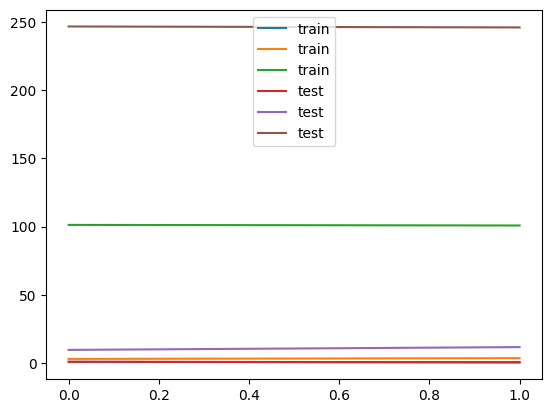

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_losses_FC, label='train')
plt.plot(train_losses_G, label='train')
plt.plot(train_losses_D, label='train')
plt.plot(test_losses_FC, label='test')
plt.plot(test_losses_G, label='test')
plt.plot(test_losses_D, label='test')
plt.legend()
plt.show()
# save plot
plt.savefig('./Model/' + save_name + "/" + save_name + '_loss.png')

# Generate Test

In [2]:
#load model
NetG = Generator().to(device)
NetD = Discriminator().to(device)
NetG.load_state_dict(torch.load('./Model/test_batch32/test_batch32_5NetG.pth'))
NetD.load_state_dict(torch.load('./Model/test_batch32/test_batch32_5NetD.pth'))
# train with load model
NetG.train()
NetD.train()


NameError: name 'Generator' is not defined

In [71]:
# generate
NetG.eval()
NetD.eval()
image = imageExtraction("./test_img.jpg")
output = NetG.generate(image, 200)
output

100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


(tensor([[[-0.2329,  0.4325,  0.4199,  ..., -0.4702, -0.1142, -0.0098]],
 
         [[ 0.1089,  0.3625,  0.8224,  ...,  0.2763,  0.0975, -0.0043]],
 
         [[-0.1282, -0.1454, -0.1592,  ...,  0.1126,  0.7090,  0.6611]],
 
         ...,
 
         [[-0.4177,  0.1868,  0.0531,  ..., -0.5458,  0.0338, -1.4983]],
 
         [[-0.1912,  0.1032,  0.4763,  ...,  0.7547,  0.7066, -0.5460]],
 
         [[-0.1003, -0.3331, -0.0245,  ..., -0.5132,  0.0633,  0.8948]]],
        device='cuda:0'),
 [2,
  540,
  235248,
  236193,
  235248,
  235248,
  235250,
  235274,
  35351,
  235254,
  605,
  6935,
  235276,
  235248,
  235248,
  235248,
  132385,
  235248,
  235265,
  235248,
  2173,
  235274,
  235248,
  2465,
  3682,
  236193,
  18824,
  235274,
  235248,
  11200,
  235276,
  235276,
  616,
  235248,
  235248,
  235248,
  235274,
  235248,
  235248,
  2012,
  235276,
  2012,
  236193,
  235248,
  235248,
  235248,
  235265,
  618,
  235276,
  669,
  235248,
  235248,
  24255,
  618,
  14383,